<a href="https://colab.research.google.com/github/chacha715/ESAA_OB/blob/main/%EA%B3%BC%EC%A0%9C_0306_%EB%B6%84%EB%A5%98_%ED%95%B8%EC%A6%88%EC%98%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ch.3 분류**

###**3.1 MNIST**

*   MNIST 데이터셋: 손으로 쓴 70,000개의 작은 숫자 이미지들. 각 이미지에는 어떤 숫자를 나타내는지 레이블 되어 있음. 머신러닝 분야에서 자주 사용됨


In [ ]:
# MNIST 데이터셋을 내려받는 코드
from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', version=1)
mnist = fetch_openml('mnist_784',version=1, as_frame=False) #
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape
# 이미지가 70,000개 있고 각 이미지에는 784(=28*28)개의 특성이 있음. 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

(70000, 784)

In [ ]:
y.shape

(70000,)

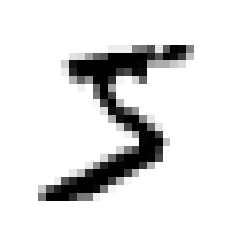

In [ ]:
# 샘플의 특성 벡터를 추출해서 28*28 배열로 크기를 바꾸고 맷플롯립의 imshow() 함수를 사용해 데이터셋에서 이미지 하나를 확인
import matplotlib as matplotlib
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# 실제 레이블 확인
y[0]

'5'

In [ ]:
# 레이블은 문자열인데 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환
import numpy as np #
y = y.astype(np.uint8)

In [ ]:
# MNIST 데이터셋에서 훈련 세트, 테스트 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]



*   훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦. 더군다나 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠지는데, 데이터셋을 섞으면 이런 문제를 방지할 수 있음
 *   (주식 가격이나 날씨 예보 같은) 시계열 데이터를 다룰 때는 섞는 것이 좋지 않음
 *   SGD는 샘플을 섞어야 하는 대표적인 경우. 사이킷런의 SGDClassifier와 SGDRegressor는 기본적으로 에포크(max_iter)마다 훈련 데이터를 다시 섞음




### **3.2 이진 분류기 훈련**
*   **이진 분류기**(binary classifier)의 한 예로 '5-감지기'-'5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 분류기

In [ ]:
# 분류를 위한 타깃 벡터 만들기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

*   사이킷런의 SGDClassifier 클래스를 사용해 **확률적 경사 하강법**(SGD) 분류기라는 모델을 선택하여 훈련. 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 것이 장점이며, SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문(그래서 SGD가 온라인 학습에 잘 맞음)

In [ ]:
# SGDClassifier 모델을 만들고 전체 훈련 세트롤 사용해 훈련
# SGDClassifier는 훈련하는 데 무작위성을 사용하므로 결과를 재현하고 싶다면 random_state 매개변수를 지정해야 함
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# 이 모델로 숫자 5의 이미지를 감지
sgd_clf.predict([some_digit])

array([ True])

*   분류기는 이 이미지가 5를 나타낸다고 추측함(True)



### **3.3 성능 측정**

### **3.3.1 교차 검증을 사용한 정확도 측정**

*   **교차 검증 구현**-사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요에 의해 직접 구현

In [ ]:
# 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력함
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) #

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

0.95035
0.96035
0.9604




*   StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든 뒤 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함
*   k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용함



In [ ]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.linear_model._glm.glm import BaseEstimator
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

*   정확도 90% 이상-이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%
*   이 예제로 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 알 수 있음. 특히 **불균형한 데이터셋**을 다룰 때 더욱 그렇다.



### **3.3.2 오차 행렬(confusion matrix)**


*   분류기의 성능을 평가하는 더 좋은 방법
*   클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것



In [ ]:
# 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
# cross_val_predict() 함수 사용
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [ ]:
# confusion_matrix() 함수를 사용해 오차 행렬 만들기
# 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])



*   오차 행렬의 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타냄
*   이 행렬의 첫 번째 행은 '5 아님' 이미지(**음성 클래스**-negative class-)에 대한 것이고, 두 번째 행은 '5' 이미지(**양성 클래스**-positive class-)에 대한 것
*   완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 됨



In [ ]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**요약된 지표**


*   **정밀도**(precision): 양성 예측의 정확도. TP/(TP+FP)

*   **재현율**(recall)=**민감도**(sensitivity)=**진짜 양성 비율**(TPR)
 
 : 분류기가 정확하게 감지한 양성 샘플의 비율. TP/(TP+FN)




### **정밀도와 재현율**

In [ ]:
# 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공함
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096/(4096+1522) ## == 3530/(3530+687)
# 5로 판별된 이미지 중 정확한 비율

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred) # == 4096/(4096+1325) ## == 3530/(3530+1891)
# 전체 숫자 5에서 감지한 비율

0.6511713705958311

*   **F1 점수**(F1 score): 정밀도와 재현율의 **조화 평균**. TP/(TP+(FN+FP)/2)

In [ ]:
# F1 점수를 계산하기 위해 f1_score() 함수 호출
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
2/(1/0.8370879772350012+1/0.6511713705958311)

0.7325171197343847



*   정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음
*   이게 항상 바람직한 것은 아니고, 상황에 따라 정밀도가 중요할 수도, 재현율이 중요할 수도 있음



### **3.3.4 정밀도/재현율 트레이드오프**

*   SGDClassifier 분류기는 **결정 함수**(decision function)를 사용하여 각 샘플의 점수를 계산. 이 점수가 **결정 임곗값**보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당
*   사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능



In [ ]:
# 분류기의 predic() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있고, 이를 기반으로 원하는 임곗값을 정해 예측할 수 있음
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # ## predict() 메서드도 decision_function() 함수를 사용하여 0보다 큰 경우를 양성으로 예측함

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# 임곗값을 높이면 재현율이 줄어듬

array([False])

In [ ]:
# 적절한 임곗값 구하기-cross_val_predict() 함수로 훈련 세트에 있는 모든 샘플의 점수를 구하기. 예측 결과가 아니라 결정 점수를 반환받도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
# 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

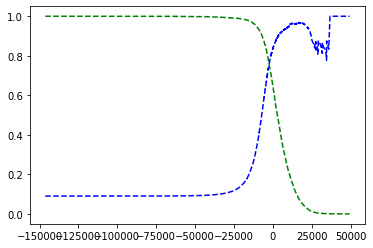

In [ ]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g--", label="재현율")
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



*   좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것. 정밀도가 급격하게 줄어들기 시작하는 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음
*   average_precision_score() 함수를 사용하면 정밀도/재현율 곡선의 아래 면적을 계산할 수 있어서 서로 다른 두 모델을 비교하는 데 도움이 됨


In [ ]:
# 정밀도 90%를 달성하는 것이 목표
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기-np.argmax()는 최댓값의 첫 번째 인덱스를 반환. 여기에서는 첫 번째 True 값을 의미
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #~7816

In [ ]:
# (훈련 세트에 대한) 예측을 만들려면 분류기의 predict() 메서드를 호출하는 대신 다음 코드를 실행
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# 예측에 대한 정밀도와 재현율 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### **3.3.5 ROC 곡선**

*   **수신기 조작 특성**(ROC) 곡선도 이진 분류에서 널리 사용하는 도구
*   정밀도에 대한 재현율 곡선이 아니고 **거짓 양성 비율**(FPR)에 대한 **진짜 양성 비율**(=재현율, TPR)의 곡선
*   **민감도**(재현율)에 대한 1-**특이도(TNR)** 그래프



In [ ]:
# roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

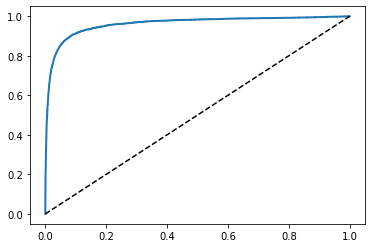

In [ ]:
# 맷플롯립을 사용해 TPR에 대한 FPR 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
  [...] # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

*   트레이드오프: 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남
*   점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻하며, 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함(왼쪽 위 모서리)
*   **곡선 아래의 면적**(AUC)을 측정하면 분류기들을 비교할 수 있음. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5

In [ ]:
# ROC의 AUC를 계산하는 함수
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616



*   양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 => PR 곡선 사용
*   그렇지 않으면 => ROC 곡선 사용




*   RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교
 *   RandomForestClassifier에는 decision_function() 메서드가 없는 대신 predict_proba() 메서드가 있음
 *   predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함





In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
# roc_curve() 함수는 레이블과 점수를 기대하는데, 점수 대신에 클래스 확률을 전달할 수 있음
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPytho

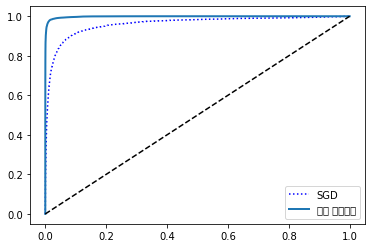

In [ ]:
# ROC 곡선과 첫 번째 ROC 곡선을 함께 그려 비교하기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()



*   RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임
*   당연히 ROC AUC 점수도 훨씬 높음



In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### **3.4 다중 분류**

*   **다중 분류기**(multiclass classifier) 또는 **다항 분류기**(multinomial classifier)는 둘 이상의 클래스를 구별할 수 있음
 *   SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리 가능
 *   로지스틱 회귀나 서포트 벡터 머신 분류기 같은 다른 알고리즘은 이진 분류만 가능
*   이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음
 *   OvR(one-versus-the-rest) 또는 OvA(one_versus_one): 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
 *   OvO(one-versus-one): 각 숫자의 조합마다 이진 분류기를 훈련. 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것
*   대부분의 이진 분류 알고리즘에서는 OvR을 선호(예외: 서포트 벡터 머신)
*   다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행함



In [ ]:
# sklearn.svm.SVC 클래스로 서포트 벡터 머신 분류기를 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용합니다.
svm_clf.predict([some_digit])
# 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해 SVC를 훈련시킨 다음 예측 하나를 만듦
# 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택함

array([5], dtype=uint8)

In [ ]:
# decision_function() 메서드를 호출하면 (1개가 아니라) 샘플당 10개의 점수를 반환함. 이 점수는 클래스마다 하나씩
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
# 가장 높은 점수가 클래스 5에 해당하는 값

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

*   liblinear 라이브러리를 사용하는 LinearSVC는 기본적으로 OvR 전략을 사용함. SVC 클래스가 사용하는 libsvm 라이브러리는 OvO 전략을 사용

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

*   (주의) 분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장함

In [ ]:
# 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

KeyboardInterrupt: ignored

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
# SGDClassifier(또는 RandomForestClassifier) 훈련시키기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
# SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없음
# decision_function() 메서드는 클래스마다 하나의 값을 반환함
sgd_clf.decision_fuction([some_digit])

In [ ]:
# 분류기 평가-교차 검증 사용
# cross_val_score() 함수를 사용해 SGDClassifier의 정확도를 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# 입력 스케일을 조정하면 정확도를 높일 수 있음
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### **3.5 에러 분석**

*   모델 선정 후 모델의 성능을 향상시킬 방법: 에러의 종류를 분석하는 것



In [ ]:
# 오차 행렬 살펴보기-cross_val_predict() 함수를 사용해 예측을 만들고 이전처럼 confusion_matrix() 함수를 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# 오차 행렬을 맷플롯립의 matshow() 함수를 사용해 이미지로 표현하기
plt.matshow(conf_mx, cmap=plt.cm.gray) ## 배열에서 가장 큰 값은 흰색으로, 가장 작은 값은 검은색으로 정규화되어 그려짐
plt.show()



*   대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임
*   숫자 5는 다른 숫자보다 조금 더 어두워 보임-데이터셋에 숫자 5의 이미지가 적가나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻



In [ ]:
# 그래프의 에러 부분에 초점-오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()



*   행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄
*   클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시하며 클래스 8의 행은 나쁘지 않으므로 실제 8이 적절히 8로 분류되었음을 알 수 있음
*   오차 행렬은 반드시 대칭인 것은 아님
*   성능 향상 방안:
 *   8로 잘못 분류되는 것을 줄이도록 개선-8처럼 보이지만 8이 아닌 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습
 *   분류기에 도움될 만한 특성 착기-동심원 수를 세는 알고리즘, 동심원 같은 패턴이 드러나도록 이미지 전처리



In [ ]:
# 3과 5의 샘플 그리기-plot_digits()는 맷플롯립의 imshow() 함수를 사용하는 함수
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()



*   왼쪽의 블록 두 개는 3으로 분류된 이미지이고 오른쪽 블록 두 개는 5로 분류된 이미지
*   분류기가 실수한 이유를 이해하기 어려움-선형 모델인 SGDClassifier를 사용했기 때문
 *   선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함
 *   3과 5는 몇 개의 픽셀만 다르기에 모델이 쉽게 혼동
 *   3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치-분류기는 이미지의 위치나 회전 방향에 매우 민감함
 *   3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것



 ### **3.6 다중 레이블 분류**

 *   여러 개의 이진 꼬리표를 출력하는 분류 시스템


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) ## 숫자가 큰 값(7,8,9)인지 나타냄
y_train_odd = (y_train % 2 == 1) ## 홀수인지 나타냄
y_multilabel = np.c_[y_train_large, y_train_odd] ## 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 배열

knn_clf = KNeighborsClassifier() ## KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련-결정트리, 랜덤 포레스트, OneVsRestClassifier도 가능
knn_clf.fit(X_train, y_multilabel)

In [ ]:
# 예측
knn_clf.predict([some_digit])
#숫자 5는 크지 않고(False) 홀수(True)이다.

In [ ]:
# 모든 레이블에 대한 F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

### **3.7 다중 출력 분류**

*   다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

In [ ]:
# MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint() 함수를 사용하여 픽셀 강도에 잡음을 추가
# 타깃 이미지는 원본 이미지
noise=np.random.randint(0,100,(len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[30]])
plot_digits(clean_digit)